# This is the classifier for the butterfly dataset

Below there is the machine learning workflow pipeline

Import packages and device selection

In [ ]:
import os
import cv2
from PIL import Image
import atom
import atom.data_cleaning as dc
import atom.feature_engineering as fe
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
path = '../data/images'
pixels_per_side = 224
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
print("Using device: ", device)

Using device:  cuda


## Dataset building and preprocessing

In [37]:
data = []
labels = []
folder = os.listdir(path)
for file in folder:
    img = cv2.imread(str(os.path.join(path, file)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (pixels_per_side, pixels_per_side))
    data.append(img)
    labels.append(int(file[:3]) - 1)
labels = np.array(labels)
#labels = labels.reshape(-1, 1)
label_dict = {0: 'Danaus plexippus',
              1: 'Heliconius charitonius',
              2: 'Heliconius erato',
              3: 'Junonia coenia',
              4: 'Lycaena phlaeas',
              5: 'Nymphalis antiopa',
              6: 'Papilio cresphontes',
              7: 'Pieris rapae',
              8: 'Vanessa atalanta',
              9: 'Vanessa cardui'}

In [38]:
print([label_dict[labels[i]] for i in range(10)]) 

['Lycaena phlaeas', 'Vanessa cardui', 'Vanessa cardui', 'Junonia coenia', 'Lycaena phlaeas', 'Nymphalis antiopa', 'Papilio cresphontes', 'Danaus plexippus', 'Pieris rapae', 'Nymphalis antiopa']


In [39]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        data = Image.fromarray(data, mode='RGB')
        if self.transform:
            data = self.transform(data)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)
        return data, labels

In [40]:
trans = transforms.Compose([
    transforms.ToTensor()
])
dataset = MyDataset(data, labels, transform=trans)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
total_sum = torch.zeros(3)
total_count = 0
for images, _ in dataloader:
    total_sum += images.sum(dim=[0, 2, 3])
    total_count += images.numel() / images.shape[1]
mean = total_sum / total_count
sum_of_squared_diff = torch.zeros(3)
for images, _ in dataloader:
    sum_of_squared_diff += ((images - mean.unsqueeze(1).unsqueeze(2))**2).sum(dim=[0, 2, 3])
std = torch.sqrt(sum_of_squared_diff / total_count)
mean = [mean[0].item(), mean[1].item(), mean[2].item()]
std = [std[0].item(), std[1].item(), std[2].item()]

In [41]:
print(mean, std)

[0.4616279900074005, 0.4468429684638977, 0.3207762539386749] [0.2861473262310028, 0.2681962549686432, 0.27681371569633484]


#### Display some samples

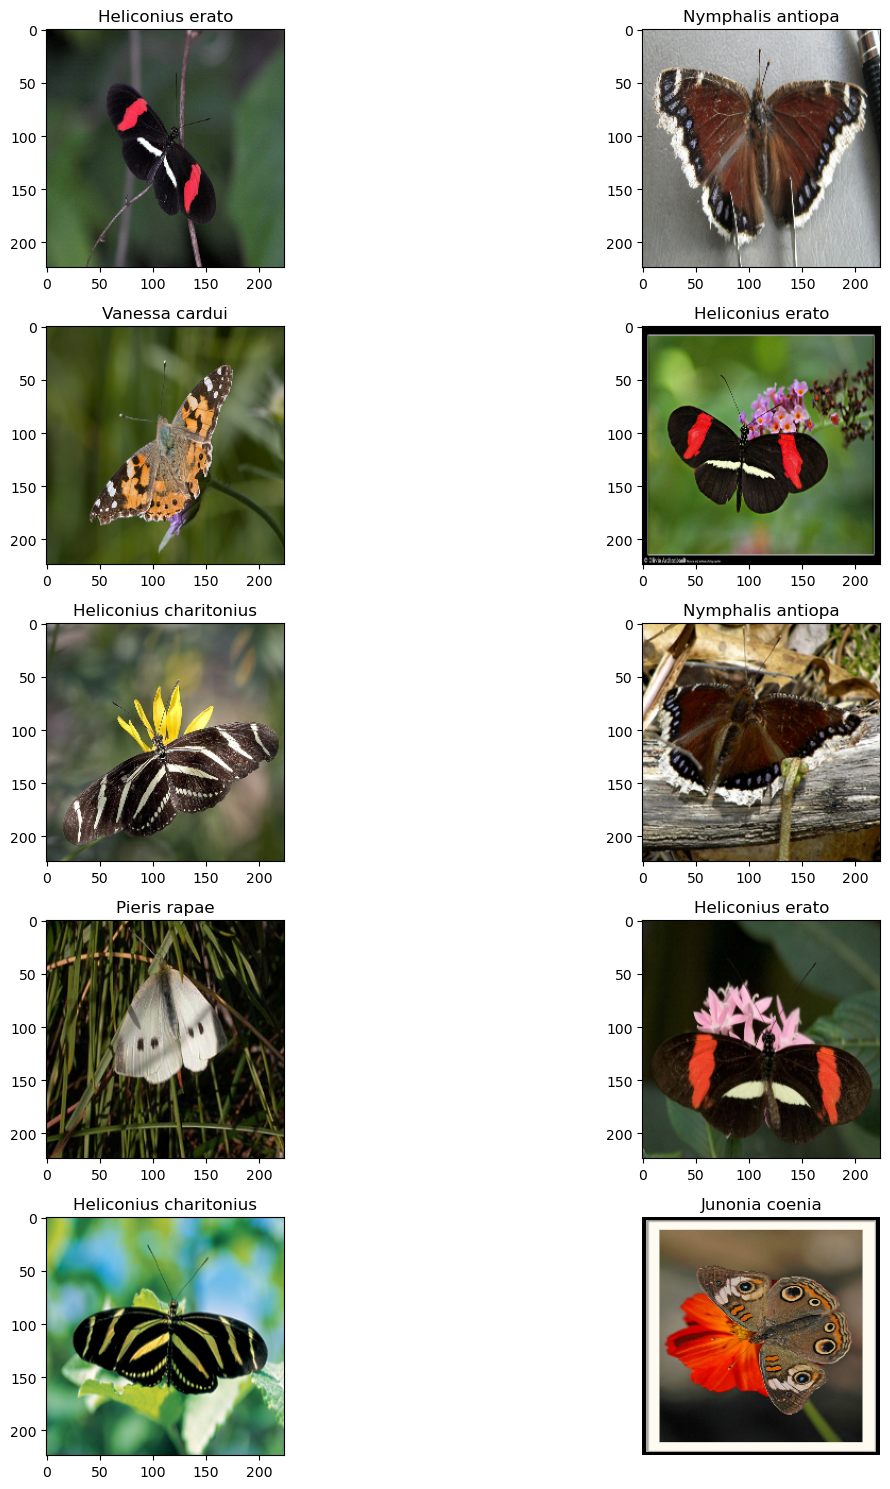

In [42]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(labels))
        ax[i,j].imshow(data[l])
        ax[i,j].set_title(str(label_dict[labels[l]]))
plt.axis('off')        
plt.tight_layout()

#### Display dataset distribution

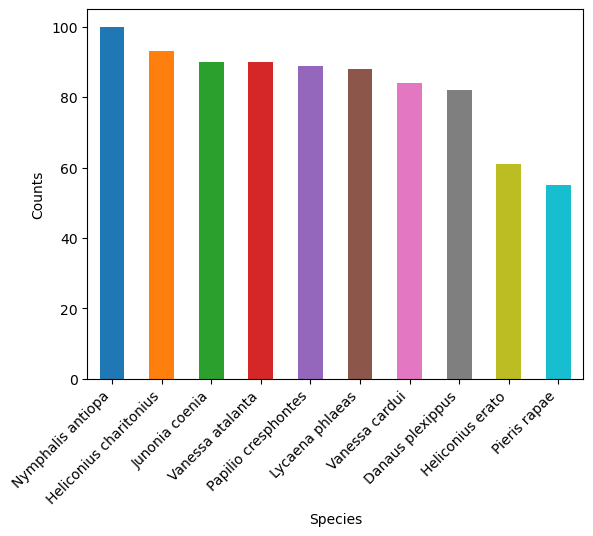

In [43]:
df = pd.DataFrame(labels, columns=['labels'])
df['labels'] = df['labels'].map(label_dict)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [cycle[i % len(cycle)] for i in range(len(df['labels'].unique()))]
df['labels'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Species')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

## Data cleaning

Use this to check dataset shape

In [52]:
print(data.shape, labels.shape)
print(data)
print(labels)

(820, 224, 224, 3) (820,)
[[[[-0.8457886   0.27862316 -1.1446495 ]
   [-0.7635603   0.30786717 -1.0596486 ]
   [-0.6676272   0.3663552  -0.9321473 ]
   ...
   [-0.10573377  0.4540873  -0.42214194]
   [ 0.12724642  0.5125753  -0.11047199]
   [ 0.25058898  0.9951017   0.272032  ]]

  [[-0.81837916  0.29324517 -1.0596486 ]
   [-0.7909697   0.29324517 -1.1588163 ]
   [-0.70874137  0.3371112  -1.0738155 ]
   ...
   [-0.07832434  0.4687093  -0.35130787]
   [ 0.00390397  0.4540873  -0.19547288]
   [ 0.20947485  0.81963754  0.14453065]]

  [[-0.7635603   0.3224892  -0.8188128 ]
   [-0.777265    0.30786717 -1.1446495 ]
   [-0.7498556   0.30786717 -1.1588163 ]
   ...
   [-0.03721019  0.5125753  -0.266307  ]
   [-0.10573377  0.42484325 -0.25214013]
   [ 0.18206541  0.6295514   0.01702933]]

  ...

  [[-0.00980075  1.0389677  -0.4788092 ]
   [-0.00980075  1.0828338  -0.3654747 ]
   [-0.06461962  1.0974557  -0.35130787]
   ...
   [-0.3524187   0.29324517 -0.42214194]
   [-0.4483517   0.2055131  -0.

In [45]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dataset = MyDataset(data, labels, transform=trans)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
data = []
for img, _ in dataloader:
    data.append(img.numpy())
data = np.concatenate(data, axis=0).transpose((0, 2, 3, 1))

Flatten data for ingestion to Atom objects

In [47]:
data = data.reshape(len(data), -1)

For a classification task, you can follow these steps in the given order to ensure your data is clean and ready for modeling:

* **Handling Outliers**: Detect and manage outliers in your dataset.
* **Balancing the Data**: Use the Balancer class to address any class imbalance during cross validation.
* **Scaling the Feature Set**: Standardize your dataset to ensure all features are on a similar scale.

This sequence helps in systematically preparing your data for a classification model.

In [49]:
data, labels = (dc.Pruner(strategy=['lof', 'iforest'],
                          device='cpu',
                          engine='sklearn',
                          verbose=2,
                          iforest={'contamination': 'auto', 'bootstrap': True, 'n_jobs': -1, 'random_state': 1},
                          lof={'n_neighbors': 20, 'contamination': 'auto', 'n_jobs': -1}
                          )
                .fit_transform(data, labels))

Fitting Pruner...
Pruning outliers...
 --> The LocalOutlierFactor detected 12 outliers.
 --> The IsolationForest detected 277 outliers.
 --> Dropping 12 outliers.


In [51]:
data = data.values.reshape(-1, pixels_per_side, pixels_per_side, 3)
labels = labels.values
cat_labels = F.one_hot(torch.tensor(labels, requires_grad=False), num_classes=10).numpy()

## Trainset preparation